In [5]:
import os 
import matplotlib
import calendar

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt, butter, filtfilt
from dataset import Dataset, ActivityType, SAMPLE_RATE, Sensor

## 1.Load the dataset from original source 

In [172]:
!wget -c --timeout 10 https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip -O dataset.zip
!unzip -d dataset -q dataset.zip
!echo "Done!"

--2023-08-17 11:55:16--  https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

replace dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Done!


In [ ]:
!ls dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/

id00b70b13.csv id3e3e50c7.csv id82b9735c.csv idb221f542.csv idf540d82b.csv
id079c763c.csv id4ea159a8.csv id86237981.csv idbae5a811.csv idf5e3678b.csv
id1165e00c.csv id5308a7d6.csv id8af5374b.csv idc735fc09.csv idfc5f05e4.csv
id1c7e64ad.csv id5993bf4a.csv id8e66893c.csv idc91a49d0.csv idff99de96.csv
id1f372081.csv id650857ca.csv id9603e9c3.csv idd80ac2b4.csv
id34e056c8.csv id687ab496.csv ida61e8ddf.csv idecc9265e.csv
id37a54bbf.csv id7c20ee7a.csv idabd0c53c.csv idf1ce9a0f.csv


In [6]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## 2. Read dataset, start explortory data analysis
- Using Dataset Class initialize an object and have an overview of the whole dataframe. 
- Visualize different activity types by bar chart.
- Choosing one of the activity and plot it to see if there's any insight from it.We might find some certain frequency patterns of it.


In [7]:
dset = Dataset("./dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data")
dset._df
sample_df=pd.read_csv('dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/id00b70b13.csv')
sample_df

,activity,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z
0,99,0.01,0.039,1.020,-0.020,-0.180,1.234,0.023,0.156,0.855,-0.582,0.887,0.449,0.074
1,99,0.02,-0.629,-0.461,0.973,-0.246,0.137,0.969,-0.707,0.559,0.449,-0.027,0.141,0.934
2,99,0.03,-0.926,-1.262,0.691,0.238,-0.328,1.219,-1.445,1.367,0.367,-0.164,0.660,1.344
3,99,0.04,-0.871,-1.496,-0.246,0.711,-0.484,0.414,-1.660,1.645,-0.543,-0.141,1.027,0.707
4,99,0.05,-0.727,-1.621,-0.559,1.031,-0.297,0.145,-1.762,1.676,-0.918,-0.121,1.230,0.438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303295,99,3032.96,0.172,-0.930,-0.320,0.000,0.000,0.000,0.160,0.020,0.977,-0.070,0.000,0.969
303296,99,3032.97,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.980,-0.070,0.000,0.969
303297,99,3032.98,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.977,-0.070,0.000,0.969
303298,99,3032.99,0.172,-0.930,-0.320,0.000,0.000,0.000,0.156,0.020,0.980,-0.070,0.000,0.969


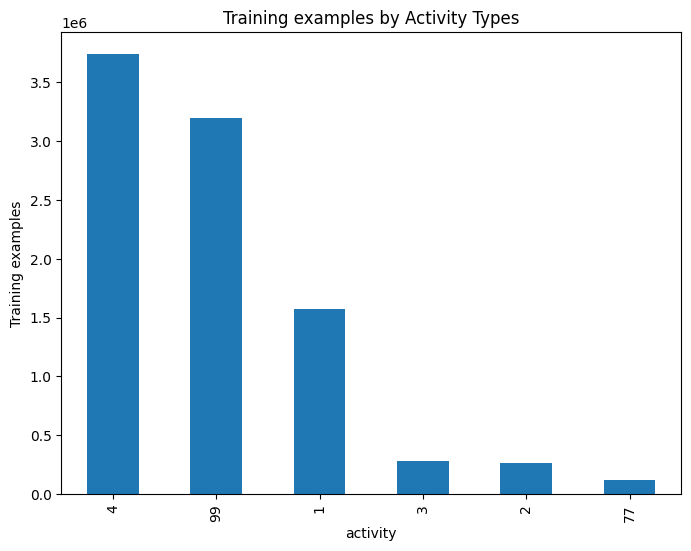

In [8]:
plt.xlabel('Activity Type')
plt.ylabel('Training examples')
dset._df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

In [9]:
activity_name = ActivityType(1).name
activity_name

'WALKING'

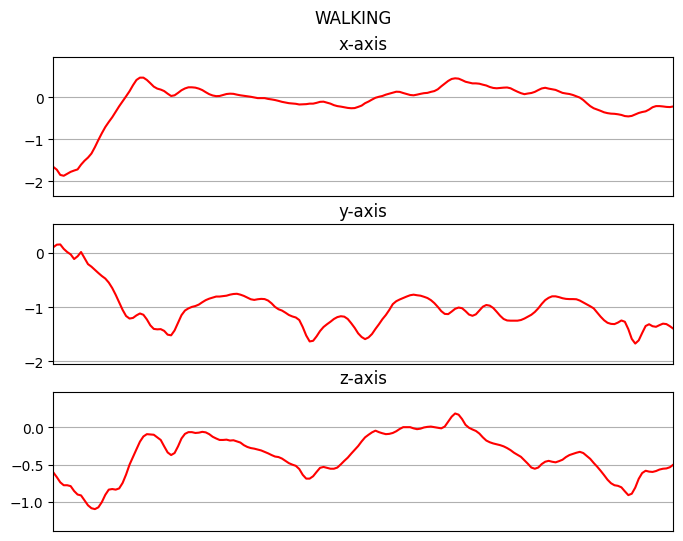

In [10]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in dset._df['activity'].unique():
    if activity == 99 or activity == 77 or activity ==4:
        continue
    limit = dset._df[dset._df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True)
    axis_plot(ax0, limit['timestamp'], limit['lw_x'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['lw_y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['lw_z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(ActivityType(activity).name)
    plt.subplots_adjust(top=0.9)
    plt.show()
    break
    

In [11]:
# separate each activity based on the numebr
def separate_activity(df,activity):
    if activity == 99:
        df_non_study = df[df['activity'] == 99]
        return df_non_study
    elif activity == 77:
        df_clapping = df[df['activity'] == 77]
        return df_clapping
    elif activity ==4:
        df_driving = df[df['activity'] == 4]
        return df_driving
    elif activity ==3:
        df_ascending_stairs = df[df['activity'] == 3]
        return df_ascending_stairs
    elif activity ==2:
        df_descending_stairs = df[df['activity'] == 2]
        return df_descending_stairs
    elif activity ==1:
        df_walking = df[df['activity'] == 1]
        return df_walking

In [12]:
def make_x_y_z_plot(df):
    # colors = ["#F7F3E3","#7F7CAF","#78C0E0"]
    option_colors = sns.color_palette()
    colors =[option_colors[0],option_colors[1],option_colors[2]]
    # create larger subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
        # Plotting
    for i, (ax, variables) in enumerate(zip(axs.flat, [('lw_x', 'lw_y', 'lw_z'), ('lh_x', 'lh_y', 'lh_z'), ('la_x', 'la_y', 'la_z'), ('ra_x', 'ra_y', 'ra_z')])):
        for variable, color in zip(variables, colors):
            sns.lineplot(data=df, x='time_s', y=variable, ax=ax, linewidth=0.5, color=color, label=variable)
        
        ax.legend(loc='upper right', fontsize=12)
        ax.set_title(' vs time_s '.join(variables), fontsize=16)
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel('Value', fontsize=14)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

#### This is one example from all the datasets, and the activity is walking, and lw,lh,la,ra each stands for left wrist, left hip, left ankle,and right ankel.from above we can see that there is no significant difference between them, since they're from the same activity.
- Plotting for Walking

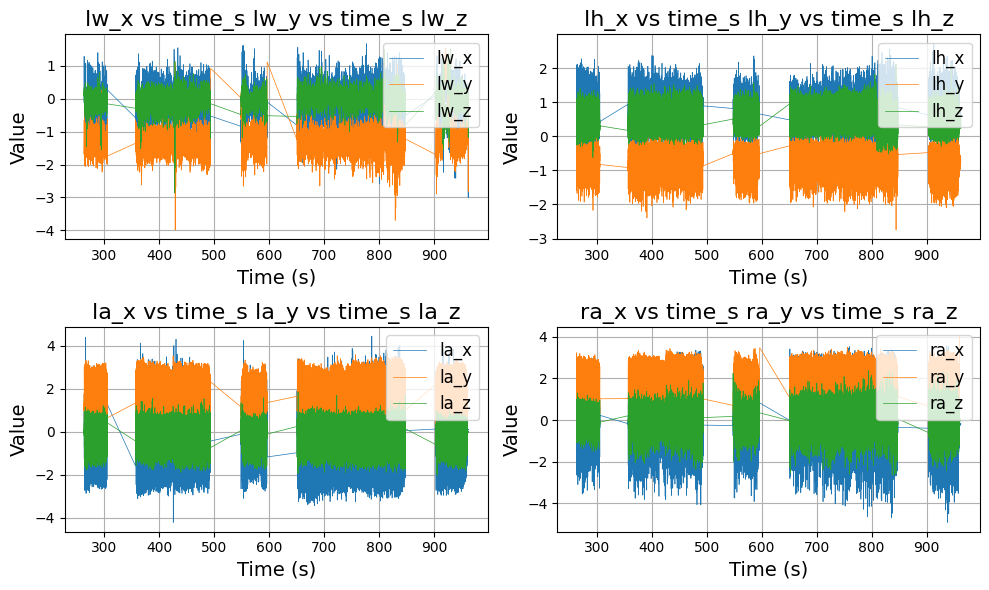

In [13]:
df = separate_activity(sample_df,1)
make_x_y_z_plot(df)

- Plotting for Descending stairs

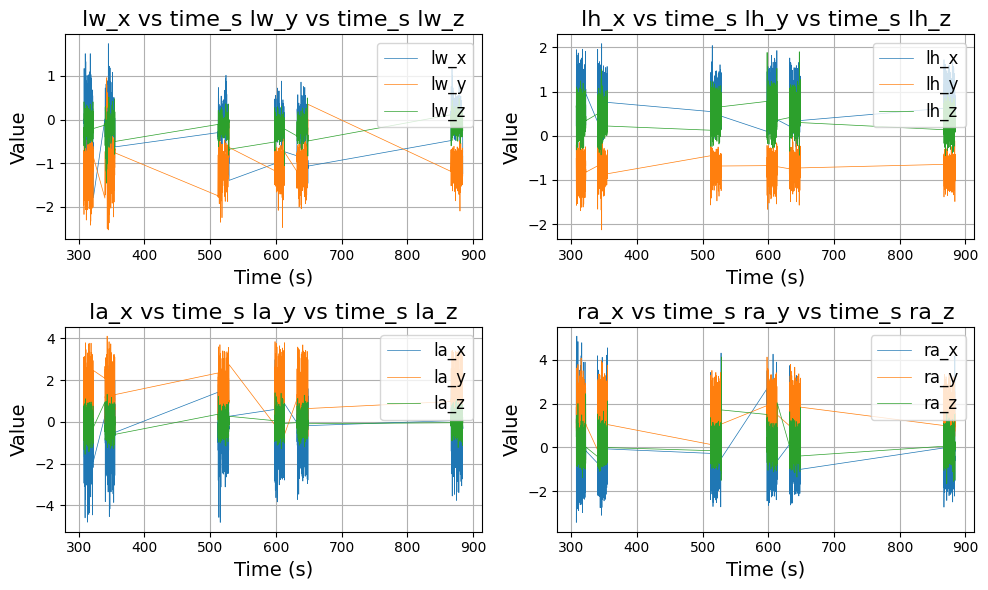

In [14]:
df = separate_activity(sample_df,2)
make_x_y_z_plot(df)

- Plotting for Ascending stairs

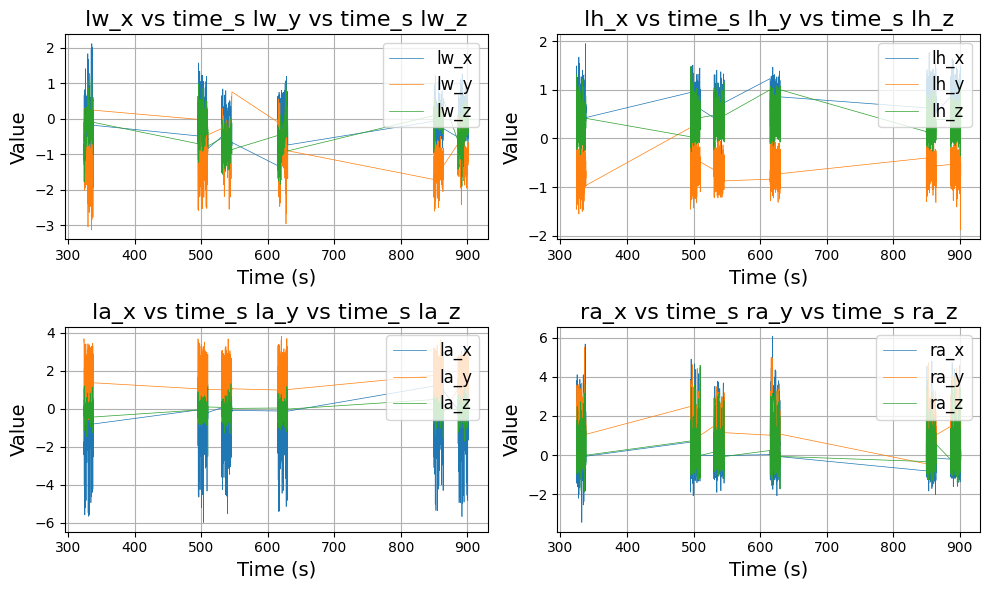

In [15]:
df = separate_activity(sample_df,3)
make_x_y_z_plot(df)

### 3.Transforming by using vector magnitude

- After the initial plotting, we may have a rough idea how the plotting looks like, but there are too many vairables, it creates some trouble when doing analysis, I refer to this paper:[Differentiating Between Walking and Stair Climbing Using Raw Accelerometry Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7453603/pdf/nihms-1529153.pdf), the suggested idea is to consolidate the multimensional, the x,y,z into a single measure, which is the vector magnitude, this can help reduce the amount of variables, also can remove the effects of sensor orientation(caused by users swinging their arms.)


- The formula of vector magnitude can be described as:

    $vm = \sqrt{x^2 + y^2 + z^2}$ <br>

- This formula consolidates the three axes data into a single measure by taking the Euclidean distance in the 3D space.


In [16]:
def calculate_vector_magnitude(df):
    df_transformed = df.copy()
    columns_to_calculate_VM = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    for i in range(0,len(columns_to_calculate_VM),3):
        x_col = columns_to_calculate_VM[i]
        y_col = columns_to_calculate_VM[i+1]
        z_col = columns_to_calculate_VM[i+2]
        magnitude_col = f"magnitude_{i//3}"
        # Calculate vector magnitude while removing sensor orientation
        df_transformed[magnitude_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)
    # print(df_transformed.columns)
    return df_transformed


### 4.Data processing
- **Apply noise filtering**
<p>Real-world data always contains noises, so here I applies a low-pass filter to remove the high-frequency noise, making the data smoother and easier to analyse.</p>

- **Data standardization** 
<p>By standardizing, I tranform the data to have a mean of zero and a std of one. This ensures all the features have the same scale, which is vital for many ml algorithms.</p>

- **Data segmentation**
<p>By choosing the window size of 5.12(size of window in seconds), and overlapping percentage as 50%, I break the data into smaller windows, this can help reduce the amount of data I need to deal with, and also can help in capturing the temporal nature of activities and making the patterns more recognizble for classification.</p>
    

In [17]:


def butter_lowpass(cutoff, fs, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(df, columns, cutoff, fs, order=3):
    df_filtered = df.copy()
    for column in columns:
        b, a = butter_lowpass(cutoff, fs, order=order)
        df_filtered[column] = filtfilt(b, a, df[column].values)
    return df_filtered
    
def apply_noise_filter(df):
    # Assuming you want to apply a median filter and low-pass Butterworth filter
    # columns_to_apply_filter = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    columns_to_apply_filter = ['magnitude_0','magnitude_1', 'magnitude_2', 'magnitude_3']

    # Apply median filter to the specified columns
    df_filtered = df.copy()
    for column in columns_to_apply_filter:
        df_filtered[column] = medfilt(df[column], kernel_size=5)  # Adjust kernel size as needed

    # Apply low-pass Butterworth filter to the filtered data
    cutoff_freq = 0.2  # Corner frequency in Hz
    order = 3  # Butterworth filter order
    fs = 100  # Sample rate (assuming equally spaced samples)
    df_filtered = butter_lowpass_filter(df_filtered, columns_to_apply_filter, cutoff_freq, fs, order)

    return df_filtered
    
def standardize(df):
    # initialize standard scaler
    scaler = StandardScaler()
    # select the columns to standardize
    # columns_to_standardize = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    
    columns_to_standardize = ['magnitude_0','magnitude_1', 'magnitude_2', 'magnitude_3']

    # standardize the columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    # Convert the 'time_s' column to a datetime format if it isn't already
    df['time_s'] = pd.to_datetime(df['time_s'], unit='s') 
    # Set the 'time_s' column as the index of the DataFrame
    df.set_index('time_s', inplace=True)
        # check if the data has been standardized
    # print(df[columns_to_standardize].mean())  # should be close to 0
    # print(df[columns_to_standardize].std())   # should be close to 1

    # Reset the index back to RangeIndex
    df.reset_index(inplace=True)
    # Convert 'time_s' back to its original unit
    df['time_s'] = df['time_s'].astype(int)

    return df

In [18]:
# standardize and segmentation
def data_processed(df):
    
    df_new = standardize(df)
    # Assuming your preprocessed data is stored in the DataFrame 'df_preprocessed'
    df_filtered = apply_noise_filter(df_new)

    # window_size = 3  # Size of each window in seconds
    window_size = [5.12,10.24]
    overlap = 0.5  # Overlap percentage (50%)
    sampling_rate = 100  # Sampling rate of your data (samples per second)
    #(i.e. 2.56s × 100Hz *0.5 =  128 sample ref: paper1

    # Calculate the number of data points in each window
    window_length = int(window_size[0] * sampling_rate)

    # Calculate the number of data points to shift the window by for the given overlap
    shift_length = int(window_length * overlap)

    # Initialize an empty list to store the segmented data
    segmented_data = []

    # Iterate over the data using a sliding window
    start_index = 0
    while start_index + window_length <= len(df_filtered):
        end_index = start_index + window_length
        segment = df_filtered.iloc[start_index:end_index]
        segmented_data.append(segment)
        start_index += shift_length

    # Concatenate the segmented data into a new DataFrame
    df_segmented = pd.concat(segmented_data)

    # Reset the index of the segmented DataFrame
    df_segmented.reset_index(drop=True, inplace=True)


    return df_filtered


### 5.Extract data insights
- mean
- variance
- maximum
- Minimum

In [19]:
def statistical_extraction(data_processed,activity_name):
    results = []
    # calculate mean,std,variance,minimum,maximun,
    mean = np.mean(data_processed)
     # Calculate standard deviation
    std = np.std(data_processed)

    # Calculate variance
    variance = np.var(data_processed)

    # Calculate minimum
    minimum = np.min(data_processed)

    # Calculate maximum
    maximum = np.max(data_processed)
    result = {
            'activity': f'{activity_name}',
            'mean': mean,
            'std': std,
            'variance': variance,
            'minimum': minimum,
            'maximum': maximum
        }
        
    results.append(result)


    return results


In [20]:
from scipy.fftpack import fft, ifft

variables = {
    'magnitude_0': 'lw',
    'magnitude_1': 'lh',
    'magnitude_2': 'la',
    'magnitude_3': 'ra'
}

### 6.Using FFT to visualize the frequency change
- FFT can break down a time-based signal into its constituent frequencies. This is useful as different activities might have distinct frequency components.


In [21]:
def FFT_plot(fft_results, labels):
    N = len(fft_results[0])
    sampling_rate = 100  # Assuming a sampling rate of 100 Hz
    frequencies = np.fft.fftfreq(N, d=1/sampling_rate)
    
    # Plot the FFT results
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")
    
    for fft_result, label in zip(fft_results, labels):
        ax.plot(frequencies, fft_result, label=label)
    
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.set_title('FFT Results')
    ax.legend()
    ax.grid(True)
    plt.show()
def FFT_DWT(VM, variables):
    fft_results = []
    labels = []
    for key, label in variables.items():
        X = fft(VM[key].values)
        fft_result = np.abs(X)
        print(f'FFT result for {label}:', fft_result)
        fft_results.append(fft_result)
        labels.append(label)


In [22]:
activity_dict = {   
        "non-study activity" : 99,
        "clapping" : 77,
        "driving" : 4,
        "ascending stairs" : 3,
        "descending stairs" : 2,
        "walking": 1
    }

In [42]:
def plot_all(df):
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")
    # variables = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]

    variables = {
    'magnitude_0': 'lw',
    # 'magnitude_1': 'lh',
    # 'magnitude_2': 'la',
    # 'magnitude_3': 'ra'
}
   
    # df.plot(x='time_s', y=variables)
    df.plot(x='time_s', y=list(variables.keys()))
    # tick_positions = range(0, 3034, 100) 
    # plt.xticks(tick_positions)
    # Adding labels and a legend
    
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend([variables[var] for var in variables.keys()])
    
    # Displaying the plot
    plt.show()

In [43]:
def method_can_do_all(sample_df,activity):
    
     
    
    # 1.read and plot
    df = sample_df
    df_activity = separate_activity(df,activity)
    df_activity_tranform = calculate_vector_magnitude(df_activity)
    # print(df_activity_tranform)
    

    # 2.standardize and downsampling and segmentation
    df_activity_processed = data_processed(df_activity_tranform)
   
    # 3. Noise filtering
    filtered_data = apply_noise_filter(df_activity_processed)
    
    # 4.statical analysis
    results = statistical_extraction(filtered_data,activity)

    plot_all(filtered_data)
   

    return results
    

In [44]:
def main():
    results = []
    for activity in activity_dict:
        if activity == "walking" or activity == "descending stairs" or activity =="ascending stairs":
            print(f"Now activity is {activity} and the code is {activity_dict[activity]}")    
            activity_results = method_can_do_all(sample_df,activity_dict[activity])
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to a CSV file
    results_df.to_csv('statistical_resultsid.id1c7e64ad.csv', index=False)

    # Display results as a table
    # print(results_df)

Now activity is ascending stairs and the code is 3


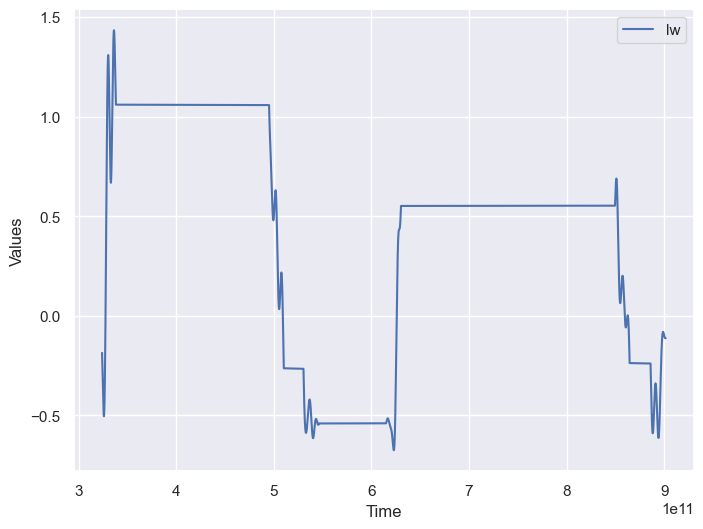

Now activity is descending stairs and the code is 2


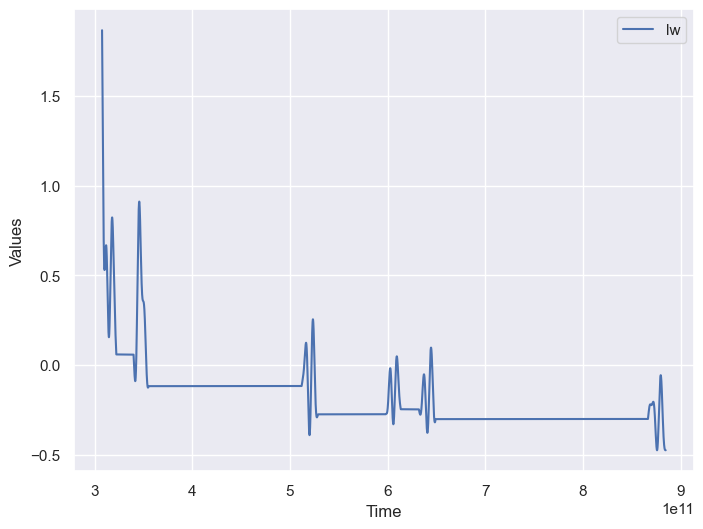

Now activity is walking and the code is 1


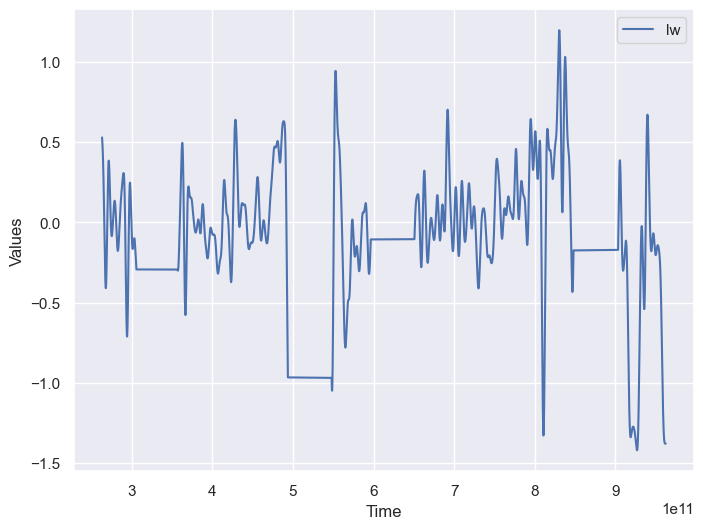

In [45]:
if __name__ == "__main__":
    main()

## Todo :
- Random Forest Classifier with GridSearch :
- Decision Trees with GridSearchCV :
- Confusion Matrix
